In [1]:
pip install transformers

In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/"MyDrive"/"Colab Notebooks"/"SST classification"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/SST classification


In [4]:
!ls

 dev.txt				   sst_test.txt
 drive-download-20211128T075322Z-001.zip   sst_train.txt
 model					   test.txt
'SST classification.ipynb'		   train.txt
 sst_dev.txt


In [5]:
import pandas as pd
from torch.utils import data
import torch

In [6]:
def read_data(fpath):
  context = []
  target = [] 
  with open(fpath) as file:
    for line in file.readlines():
      s = line.split('	')
      target.append(int(s[0][-1].strip())-1)
      context.append(s[1].strip())
      
  return context, target

# 五分類
* 0 negative
* 1 somewhat negative
* 2 neutral
* 3 somewhat positive
* 4 positive

In [7]:
count={0:0,1:0,2:0,3:0,4:0}
train_context, train_target=read_data('sst_train.txt')
val_context, val_target=read_data('sst_dev.txt')
# train_context = pd.DataFrame(train_context)
# train_target = pd.DataFrame(train_target)
print(type(train_context[0]))
print(type(train_target[0]))
for i in train_target:
  count[i]+=1
print(count)
count={0:0,1:0,2:0,3:0,4:0}
for i in val_target:
  count[i]+=1
print(count)
for i in range(5):
  print(train_context[i]," ",train_target[i])

<class 'str'>
<class 'int'>
{0: 1092, 1: 2218, 2: 1624, 3: 2322, 4: 1288}
{0: 139, 1: 289, 2: 229, 3: 279, 4: 165}
The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .   3
The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .   4
Singer/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .   3
You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .   2
Yet the act is still charming here .   3


# 將資料進行 Tokenize
## 將 input 資料轉換成 token id 、tpye_id 與 attention_mask

In [8]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_context, truncation=True, padding=True)
val_encodings = tokenizer(val_context, truncation=True, padding=True)

In [9]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [10]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

# 加入Lable

In [11]:
def add_tagets(encodings, tagets):
  encodings.update({'label': tagets})

In [12]:
add_tagets(train_encodings, train_target)
add_tagets(val_encodings, val_target)

In [13]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'label'])

In [14]:
print(train_encodings['input_ids'][0])
print(tokenizer.decode(train_encodings['input_ids'][0]))

print(train_encodings['token_type_ids'][0])
print(train_encodings['attention_mask'][0])
print(train_encodings['label'][0])

[101, 1996, 2600, 2003, 16036, 2000, 2022, 1996, 7398, 2301, 1005, 1055, 2047, 1036, 1036, 16608, 1005, 1005, 1998, 2008, 2002, 1005, 1055, 2183, 2000, 2191, 1037, 17624, 2130, 3618, 2084, 7779, 29058, 8625, 13327, 1010, 3744, 1011, 18856, 19513, 3158, 5477, 4168, 2030, 7112, 16562, 2140, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[CLS] the rock is destined to be the 21st century's new ` ` conan'' and that he's going to make a splash even greater than arnold schwarzenegger, jean - claud van damme or steven segal. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0

# 定義 Dataset，並轉換成 tensor 格式

In [15]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

  def __len__(self):
    return len(self.encodings.input_ids)


In [16]:
train_dataset = Dataset(train_encodings)
val_dataset = Dataset(val_encodings)

In [17]:
train_dataset[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  1996,  2600,  2003, 16036,  2000,  2022,  1996,  7398,  2301,
          1005,  1055,  2047,  1036,  1036, 16608,  1005,  1005,  1998,  2008,
          2002,  1005,  1055,  2183,  2000,  2191,  1037, 17624,  2130,  3618,
          2084,  7779, 29058,  8625, 13327,  1010,  3744,  1011, 18856, 19513,
          3158,  5477,  4168,  2030,  7112, 16562,  2140,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]),
 'label': tensor(3),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0,

In [18]:
from transformers import BertConfig, BertForSequenceClassification
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=5)  #num_labels 設定類別數
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
!pip install datasets
!pip install accelerate

     |████████████████████████████████| 298 kB 4.2 MB/s 
     |████████████████████████████████| 243 kB 44.4 MB/s 
     |████████████████████████████████| 1.1 MB 27.7 MB/s 
     |████████████████████████████████| 132 kB 59.1 MB/s 
     |████████████████████████████████| 160 kB 71.3 MB/s 
     |████████████████████████████████| 192 kB 62.2 MB/s 
     |████████████████████████████████| 271 kB 73.2 MB/s 
     |████████████████████████████████| 58 kB 2.6 MB/s 


In [21]:
import logging
import datasets
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
import math

import transformers
from accelerate import Accelerator
from transformers import (
    AdamW,
    AutoConfig,
    default_data_collator,
    get_scheduler
)

In [22]:
train_batch_size = 40      # 設定 training batch size
eval_batch_size = 20      # 設定 eval batch size
num_train_epochs = 10      # 設定 epoch 

In [23]:
data_collator = default_data_collator
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=data_collator, batch_size=train_batch_size)
val_dataloader = DataLoader(val_dataset, collate_fn=data_collator, batch_size=eval_batch_size)

In [24]:
learning_rate=2e-5          # 設定 learning_rate
gradient_accumulation_steps = 1   # 設定 幾步後進行反向傳播

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },                                
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

# Scheduler and math around the number of training steps.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
max_train_steps = num_train_epochs * num_update_steps_per_epoch
print('max_train_steps', max_train_steps)

# scheduler
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_train_steps,
)

max_train_steps 2140


In [25]:
# Initialize the accelerator. We will let the accelerator handle device placement for us in this example.
accelerator = Accelerator()

# Prepare everything with our `accelerator`.
model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)

In [26]:
# Get the metric function

metric = load_metric("accuracy")

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [26]:
# Train!
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state)
output_dir = 'model/'


total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num Epochs = {num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {max_train_steps}")


completed_steps = 0
best_epoch = {"epoch:": 0, "acc": 0 }

for epoch in trange(num_train_epochs, desc="Epoch"):
  model.train()
  for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
    outputs = model(**batch)
    loss = outputs.loss
    loss = loss / gradient_accumulation_steps
    accelerator.backward(loss)
    if step % gradient_accumulation_steps == 0 or step == len(train_dataloader) - 1:
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      completed_steps += 1

    if step % 50 == 0:
      print({'epoch': epoch, 'step': step, 'loss': loss.item()})

    if completed_steps >= max_train_steps:
      break
      
  logger.info("***** Running eval *****")
  model.eval()
  for step, batch in enumerate(tqdm(val_dataloader, desc="Eval Iteration")):
    outputs = model(**batch)
    predictions = outputs.logits.argmax(dim=-1)
    metric.add_batch(
        predictions=accelerator.gather(predictions),
        references=accelerator.gather(batch["labels"]),
    )

  eval_metric = metric.compute()
  logger.info(f"epoch {epoch}: {eval_metric}")
  if eval_metric['accuracy'] > best_epoch['acc']:
    best_epoch['epoch'] = num_train_epochs
    best_epoch['acc'] = eval_metric['accuracy']


  if output_dir is not None:
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir + 'epoch_' + str(num_train_epochs) + '/', save_function=accelerator.save)


11/30/2021 13:29:58 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda
Use FP16 precision: False

11/30/2021 13:29:58 - INFO - __main__ - ***** Running training *****
11/30/2021 13:29:58 - INFO - __main__ -   Num examples = 8544
11/30/2021 13:29:58 - INFO - __main__ -   Num Epochs = 10
11/30/2021 13:29:58 - INFO - __main__ -   Instantaneous batch size per device = 40
11/30/2021 13:29:58 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 40
11/30/2021 13:29:58 - INFO - __main__ -   Gradient Accumulation steps = 1
11/30/2021 13:29:58 - INFO - __main__ -   Total optimization steps = 2140


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/214 [00:00<?, ?it/s]

{'epoch': 0, 'step': 0, 'loss': 1.7031980752944946}
{'epoch': 0, 'step': 50, 'loss': 1.4520976543426514}
{'epoch': 0, 'step': 100, 'loss': 1.2749950885772705}
{'epoch': 0, 'step': 150, 'loss': 1.1808148622512817}
{'epoch': 0, 'step': 200, 'loss': 0.9574621915817261}


11/30/2021 13:32:54 - INFO - __main__ - ***** Running eval *****


Eval Iteration:   0%|          | 0/56 [00:00<?, ?it/s]

11/30/2021 13:33:02 - INFO - __main__ - epoch 0: {'accuracy': 0.4822888283378747}


Iteration:   0%|          | 0/214 [00:00<?, ?it/s]

{'epoch': 1, 'step': 0, 'loss': 0.9842957258224487}
{'epoch': 1, 'step': 50, 'loss': 0.8676545023918152}
{'epoch': 1, 'step': 100, 'loss': 0.8552490472793579}
{'epoch': 1, 'step': 150, 'loss': 0.7953409552574158}
{'epoch': 1, 'step': 200, 'loss': 0.8582631945610046}


11/30/2021 13:36:05 - INFO - __main__ - ***** Running eval *****


Eval Iteration:   0%|          | 0/56 [00:00<?, ?it/s]

11/30/2021 13:36:13 - INFO - __main__ - epoch 1: {'accuracy': 0.5040871934604905}


Iteration:   0%|          | 0/214 [00:00<?, ?it/s]

{'epoch': 2, 'step': 0, 'loss': 0.8059115409851074}
{'epoch': 2, 'step': 50, 'loss': 0.7026238441467285}
{'epoch': 2, 'step': 100, 'loss': 1.1224182844161987}
{'epoch': 2, 'step': 150, 'loss': 0.7338690161705017}
{'epoch': 2, 'step': 200, 'loss': 0.5640298128128052}


11/30/2021 13:39:11 - INFO - __main__ - ***** Running eval *****


Eval Iteration:   0%|          | 0/56 [00:00<?, ?it/s]

11/30/2021 13:39:19 - INFO - __main__ - epoch 2: {'accuracy': 0.5095367847411444}


Iteration:   0%|          | 0/214 [00:00<?, ?it/s]

{'epoch': 3, 'step': 0, 'loss': 0.7755473256111145}
{'epoch': 3, 'step': 50, 'loss': 0.5150012373924255}
{'epoch': 3, 'step': 100, 'loss': 0.7305235266685486}
{'epoch': 3, 'step': 150, 'loss': 0.5309327244758606}
{'epoch': 3, 'step': 200, 'loss': 0.48743829131126404}


11/30/2021 13:42:17 - INFO - __main__ - ***** Running eval *****


Eval Iteration:   0%|          | 0/56 [00:00<?, ?it/s]

11/30/2021 13:42:24 - INFO - __main__ - epoch 3: {'accuracy': 0.49954586739327883}


Iteration:   0%|          | 0/214 [00:00<?, ?it/s]

{'epoch': 4, 'step': 0, 'loss': 0.5652325749397278}
{'epoch': 4, 'step': 50, 'loss': 0.5150234699249268}
{'epoch': 4, 'step': 100, 'loss': 0.5622268915176392}
{'epoch': 4, 'step': 150, 'loss': 0.7853455543518066}
{'epoch': 4, 'step': 200, 'loss': 0.34897249937057495}


11/30/2021 13:45:23 - INFO - __main__ - ***** Running eval *****


Eval Iteration:   0%|          | 0/56 [00:00<?, ?it/s]

11/30/2021 13:45:30 - INFO - __main__ - epoch 4: {'accuracy': 0.5031789282470481}


Iteration:   0%|          | 0/214 [00:00<?, ?it/s]

{'epoch': 5, 'step': 0, 'loss': 0.28499048948287964}
{'epoch': 5, 'step': 50, 'loss': 0.2918427586555481}
{'epoch': 5, 'step': 100, 'loss': 0.3844122886657715}
{'epoch': 5, 'step': 150, 'loss': 0.3142699599266052}
{'epoch': 5, 'step': 200, 'loss': 0.4348468780517578}


11/30/2021 13:48:29 - INFO - __main__ - ***** Running eval *****


Eval Iteration:   0%|          | 0/56 [00:00<?, ?it/s]

11/30/2021 13:48:36 - INFO - __main__ - epoch 5: {'accuracy': 0.49318801089918257}


Iteration:   0%|          | 0/214 [00:00<?, ?it/s]

{'epoch': 6, 'step': 0, 'loss': 0.1581091433763504}
{'epoch': 6, 'step': 50, 'loss': 0.11485151201486588}
{'epoch': 6, 'step': 100, 'loss': 0.19812381267547607}
{'epoch': 6, 'step': 150, 'loss': 0.22925162315368652}
{'epoch': 6, 'step': 200, 'loss': 0.33156535029411316}


11/30/2021 13:51:35 - INFO - __main__ - ***** Running eval *****


Eval Iteration:   0%|          | 0/56 [00:00<?, ?it/s]

11/30/2021 13:51:42 - INFO - __main__ - epoch 6: {'accuracy': 0.48864668483197093}


Iteration:   0%|          | 0/214 [00:00<?, ?it/s]

{'epoch': 7, 'step': 0, 'loss': 0.15604272484779358}
{'epoch': 7, 'step': 50, 'loss': 0.1416568011045456}
{'epoch': 7, 'step': 100, 'loss': 0.186350017786026}
{'epoch': 7, 'step': 150, 'loss': 0.0897192507982254}
{'epoch': 7, 'step': 200, 'loss': 0.123163603246212}


11/30/2021 13:54:41 - INFO - __main__ - ***** Running eval *****


Eval Iteration:   0%|          | 0/56 [00:00<?, ?it/s]

11/30/2021 13:54:48 - INFO - __main__ - epoch 7: {'accuracy': 0.5022706630336058}


Iteration:   0%|          | 0/214 [00:00<?, ?it/s]

{'epoch': 8, 'step': 0, 'loss': 0.3281231224536896}
{'epoch': 8, 'step': 50, 'loss': 0.1136660948395729}
{'epoch': 8, 'step': 100, 'loss': 0.16320833563804626}
{'epoch': 8, 'step': 150, 'loss': 0.2655330300331116}
{'epoch': 8, 'step': 200, 'loss': 0.09820370376110077}


11/30/2021 13:57:46 - INFO - __main__ - ***** Running eval *****


Eval Iteration:   0%|          | 0/56 [00:00<?, ?it/s]

11/30/2021 13:57:54 - INFO - __main__ - epoch 8: {'accuracy': 0.4940962761126249}


Iteration:   0%|          | 0/214 [00:00<?, ?it/s]

{'epoch': 9, 'step': 0, 'loss': 0.07426188141107559}
{'epoch': 9, 'step': 50, 'loss': 0.1905631124973297}
{'epoch': 9, 'step': 100, 'loss': 0.0961526408791542}
{'epoch': 9, 'step': 150, 'loss': 0.11477328836917877}
{'epoch': 9, 'step': 200, 'loss': 0.2634446620941162}


11/30/2021 14:00:53 - INFO - __main__ - ***** Running eval *****


Eval Iteration:   0%|          | 0/56 [00:00<?, ?it/s]

11/30/2021 14:01:00 - INFO - __main__ - epoch 9: {'accuracy': 0.49227974568574023}


In [27]:
print(best_epoch)

{'epoch:': 0, 'acc': 0.5095367847411444, 'epoch': 10}


# 分析

In [27]:
# **計算 Precision, Recall, F1-score **
from transformers import BertTokenizerFast, BertConfig, BertForSequenceClassification, default_data_collator
from torch.utils.data import DataLoader
from accelerate import Accelerator
from tqdm.auto import tqdm

In [28]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/"MyDrive"/"Colab Notebooks"/"SST classification"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/SST classification


In [29]:
!ls

 dev.txt				   sst_test.txt
 drive-download-20211128T075322Z-001.zip   sst_train.txt
 model					   test.txt
'SST classification.ipynb'		   train.txt
 sst_dev.txt


# 載入模型

In [30]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
config = BertConfig.from_pretrained("./model/epoch_10/config.json") 
model = BertForSequenceClassification.from_pretrained("./model/epoch_10/pytorch_model.bin", config=config)

# Testdata

In [31]:
eval_questions, eval_tagets = read_data('sst_test.txt')

eval_encodings = tokenizer(eval_questions, truncation=True, padding=True)
add_tagets(eval_encodings, eval_tagets)

eval_dataset = Dataset(eval_encodings)


In [32]:
eval_batch_size = 20      # 設定 batch size
data_collator = default_data_collator

eval_dataloader = DataLoader(eval_dataset, collate_fn=data_collator, batch_size=eval_batch_size)

# Initialize the accelerator. We will let the accelerator handle device placement for us in this example.
accelerator = Accelerator()

# Prepare everything with our `accelerator`.
model, eval_dataloader = accelerator.prepare(
    model, eval_dataloader
)

In [33]:
print("***** Running eval *****")
model.eval()

labels = []
predictions = []

for step, batch in enumerate(tqdm(eval_dataloader, desc="Eval Iteration")):
  outputs = model(**batch)
  predicted = outputs.logits.argmax(dim=-1)

  labels += batch["labels"].tolist()
  predictions += predicted.tolist()


***** Running eval *****


Eval Iteration:   0%|          | 0/111 [00:00<?, ?it/s]

In [34]:
import datasets
datasets.list_metrics()

['accuracy',
 'bertscore',
 'bleu',
 'bleurt',
 'cer',
 'chrf',
 'code_eval',
 'comet',
 'competition_math',
 'coval',
 'cuad',
 'f1',
 'gleu',
 'glue',
 'google_bleu',
 'indic_glue',
 'matthews_correlation',
 'meteor',
 'pearsonr',
 'precision',
 'recall',
 'rouge',
 'sacrebleu',
 'sari',
 'seqeval',
 'spearmanr',
 'squad',
 'squad_v2',
 'super_glue',
 'ter',
 'wer',
 'wiki_split',
 'xnli']

In [35]:
from datasets import load_metric

accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
print(accuracy)

precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
print(precision)

recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
print(recall)

f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
print(f1)

Downloading:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

{'accuracy': 0.5199095022624435}
{'precision': 0.5283036335013107}
{'recall': 0.5199095022624435}
{'f1': 0.5222431012093874}


In [36]:
from sklearn.metrics import classification_report

for line in classification_report(labels, predictions).split('\n'):
  print(line)

              precision    recall  f1-score   support

           0       0.55      0.43      0.48       279
           1       0.57      0.54      0.55       633
           2       0.33      0.38      0.35       389
           3       0.53      0.59      0.55       510
           4       0.65      0.60      0.62       399

    accuracy                           0.52      2210
   macro avg       0.52      0.51      0.51      2210
weighted avg       0.53      0.52      0.52      2210



In [37]:
# **產生 confusion matrix heatmap **
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

confusion matrix=


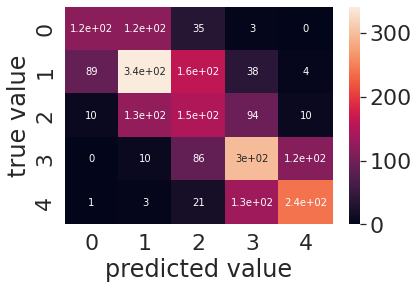

In [38]:
mat = confusion_matrix(labels, predictions)
print("confusion matrix=")
sn.set(font_scale=2) # for label size
sn.heatmap(mat, annot=True, annot_kws={"size": 10}) # font size
plt.xlabel("predicted value")
plt.ylabel("true value")
plt.show()

In [39]:
from transformers import BertTokenizerFast, BertConfig, BertForSequenceClassification

In [40]:
def sst_model(model, question):
  input_encodings = tokenizer([question], truncation=True, padding=True)
  input_dataset = Dataset(input_encodings)

  data_collator = default_data_collator
  input_dataloader = DataLoader(input_dataset, collate_fn=data_collator, batch_size=1)  

  accelerator = Accelerator()
  model, input_dataloader = accelerator.prepare(model, input_dataloader)

  for batch in input_dataloader:
    outputs = model(**batch)
    predicted = outputs.logits.argmax(dim=-1)
  return predicted

In [41]:
model_path = "./model/epoch_10/"


tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese")
config = BertConfig.from_pretrained(model_path + "config.json") 
model = BertForSequenceClassification.from_pretrained(model_path + "pytorch_model.bin", config=config)

In [43]:
answer = sst_model(model, input())
print("-------->",answer.item(),":", typedict[answer.item()])

the movie is suck
--------> 1 : somewhat negative


In [42]:
questions = ['Great flick but too short.',
        'There was too much forced comedy without enough actual plot to actually be good.',
        'This movie was amazing I wish it was longer',
        'Trash.',
        'Exciting and thrilling to watch.',
        'They’re definitely trying to bring venom into the MCU I think that’s amazing!',
        'Good followup from the first film, Hed a few issues. but overall entertaining.',
        "Very entertaining! Great action, good storyline."
      ]
for q in questions:
  answer = sst_model(model, q)
  typedict={
  0: "negative",
  1: "somewhat negative",
  2: "neutral",
  3: "somewhat positive",
  4: "positive"
  }
  print(q,"-------->",answer.item(),":", typedict[answer.item()])

  



Great flick but too short. --------> 1 : somewhat negative
There was too much forced comedy without enough actual plot to actually be good. --------> 3 : somewhat positive
This movie was amazing I wish it was longer --------> 2 : neutral
Trash. --------> 2 : neutral
Exciting and thrilling to watch. --------> 2 : neutral
They’re definitely trying to bring venom into the MCU I think that’s amazing! --------> 2 : neutral
Good followup from the first film, Hed a few issues. but overall entertaining. --------> 2 : neutral
Very entertaining! Great action, good storyline. --------> 3 : somewhat positive
